In [ ]:
import numpy as np
import pickle as pkl
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.optimize as opti
import scipy, sys, time
import matplotlib.pyplot as plt
from matplotlib import mlab as mlab
from matplotlib.mlab import psd
from tqdm import tqdm
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir

# some settings for standardized figures

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['font.size'] = (24)
plt.rcParams['xtick.labelsize']="medium"
plt.rcParams['text.usetex'] = False

In [2]:
# determine the center position of the attractor at a given time
def osci_pos_func(stroke,time,frequency): 
    osci_pos = stroke/2*np.sin(2*np.pi*time*frequency)
    return osci_pos

def osci_pos_triang_func(stroke,time,frequency,width=0.5):
    osci_pos_triang=stroke/2*signal.sawtooth(2 * np.pi * frequency * time+np.pi/2,width=width)
    return osci_pos_triang

# determine the force for a given point in time using the transformation to position
## sinusoidal movement
def osci_force_func(stroke,time,frequency,pos_vec,force_vec):
    osci_pos = osci_pos_func(stroke,time,frequency)
    return np.interp(osci_pos,pos_vec,force_vec, left=None, right=None, period=None)

## triangle movement
def osci_force_func_tri(stroke,time,frequency,pos_vec,force_vec,width=0.5):
    osci_pos_triang = osci_pos_triang_func(stroke,time,frequency,width=width)
    return np.interp(osci_pos_triang,pos_vec,force_vec, left=None, right=None, period=None)

# little helper to get the bin of a histogram at which a certain invertall in % is reached
def fraction_of_histo(input_histo,bins=500,intervall=0.68):
    hist_list =[]
    h1 = plt.hist(input_histo,bins,density=True,cumulative=True)
    [hist_list.append(h1[1][bins]) for bins in np.arange(0,len(h1[1])-1,1) if h1[0][bins]>intervall]
    plt.xlabel("ASD [Hz]")
    plt.ylabel("CDF")
    plt.axvline(np.min(hist_list),color="red",linestyle="dashed")
    plt.axhline(intervall,color="red",linestyle="dashed")
    #plt.show()
    return np.min(hist_list)
          
# normalization for used ASD
def fft_norm(N, fsamp):
    return np.sqrt(2 / (N * fsamp))

### CHECK WHITE NOISE
def generate_white_noise(length,fs,noise_floor):
    noise_randomized = noise_floor * np.random.randn(length)
    fft = np.abs(np.fft.rfft(noise_randomized))
    freq3 = np.fft.rfftfreq(length, d=1./fs)
    ps = fft*fft.conj().real*fft_norm(length,fs)**2
    return ps,freq3


def generate_white_noise2(length,fs,noise_floor):
    noise_randomized = noise_floor * np.random.randn(length)
    psd_noise,freq_n = psd(noise_randomized,NFFT=length,Fs=fs, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    norm=0.5*fs
    return psd_noise*norm,freq_n

# get noise response for a number of harmonics
def noise_response(no_harmonics,frequency,noise_floor):
    noise_response = 0
    noise_value = generate_white_noise(5000,5000,noise_floor)[0]
    for j in no_harmonics:
        noise_response += noise_value[j*frequency]
        
    return noise_response

def noise_response_per_harmonics(no_harmonics,frequency,noise_floor):
    noise_response = []
    noise_value = generate_white_noise(5000,5000,noise_floor)[0]
    for j in no_harmonics:
        noise_response.append(noise_value[j*frequency])
    return noise_response


# define a function to obtain the response given a number of harmonics (normalization)
def function_response(alpha,int_time,fs,pos_vec,force_vec,stroke,frequency,no_harmonics,plot,manual):
    force_vec = force_vec * alpha # scale the force vector by alpha
    time = np.arange(0,int_time,1/sampling_frequency) # make a time array, default 1s
    length = len(osci_force_func(stroke,time,frequency,pos_vec,force_vec)) # length of the array
    
    # calculate the psd "manually"
    fft = np.abs(np.fft.rfft(osci_force_func(stroke,time,frequency,pos_vec,force_vec))) 
    freq = np.fft.rfftfreq(length, d=1./fs)
    psd_dat1 = fft*fft.conj().real*fft_norm(len(noise_randomized),fs)**2
    
    # let mlab do the job
    psd_dat2,freq2 = psd(osci_force_func(stroke,time,frequency,pos_vec,force_vec), 
                         NFFT=length, 
                         Fs=fs, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    response =0
    if(plot==True):
        plt.plot(freq2,np.sqrt(psd_dat2))
        plt.yscale("log")
        plt.xlim(0,340)
    for i in no_harmonics:
        if(manual==True):
            response+=np.sqrt(psd_dat1[i*frequency])
        if(manual==False):    
            response+=np.sqrt(psd_dat2[i*frequency])
        #print(response,i*frequency)
    return response

In [3]:
def function_response_2(alpha,int_time,sampling_frequency,pos_vec,force_vec,stroke,frequency,no_harmonics,bkg=False,plot=False):
    force_vec = force_vec * alpha
    sampling_frequency = 5000
    time = np.arange(0,int_time,1/sampling_frequency)
    fft_0 = np.fft.rfft(osci_force_func(stroke,time,frequency,pos_vec,force_vec))
    fft_1 = np.abs(fft_0)
    freq2 = np.fft.rfftfreq(5000, d=1./5000)
    psd_dat2 = fft_1*fft_1.conj().real*fft_norm(len(osci_force_func(stroke,time,frequency,pos_vec,force_vec)),5000)**2
    
    response =0
    response_list=[]
    phase_list=[]
    if(bkg==True):frequency=frequency+2
    for i in np.arange(1,no_harmonics+1,1):
        response+=np.sqrt(psd_dat2[i*frequency])
        freq_selec = np.arange(frequency,frequency*(no_harmonics+1),frequency)
        response_list.append(np.sqrt(psd_dat2[i*frequency]))
        phase_list.append(np.angle(fft_0[i*frequency]))
    if(plot==True):            
        plt.plot(freq_selec,response_list)
        plt.yscale("log")
        plt.xlim(0,frequency*no_harmonics+5)
        plt.show()
        plt.plot(freq_selec,np.divide(phase_list,np.pi),marker="*")
        plt.xlim(0,frequency*no_harmonics+5)
        #print(response,i*frequency)
    return (response,freq_selec,response_list,phase_list)

In [319]:
## load the data dictionary file (its usually of the form results_dic[rbead][sep][height][yuklambda])
sep = 7.49e-6
res_dict_side_by_side = pkl.load( open('/home/analysis_user/New_trap_code/SensitivityFramework/results/simulation/rbead_2.4e-06_sep_%3.1e_height_0.p' %(sep), 'rb'))


In [320]:
## initate a few values in order to do diagnostics
int_time = 1 # keep that 1 for now
alpha = 1 # alpha to scale the yukawa force
sampling_frequency = 5000 # should be 5000 
time = np.arange(0,int_time,1/sampling_frequency) # make a time array
separation = 7.5e-6 # separation is set by the file you load TODO automatize
lambda_par= 1e-5 # pick a lambda parameter
force_x = res_dict_side_by_side[2.4e-6][separation][0][lambda_par][0] # force in direction of the sphere
force_x_yuk = alpha*res_dict_side_by_side[2.4e-6][separation][0][lambda_par][3] # force by the yukawa potential
pos_x = res_dict_side_by_side["posvec"] # get the position of the bead from the dictionary

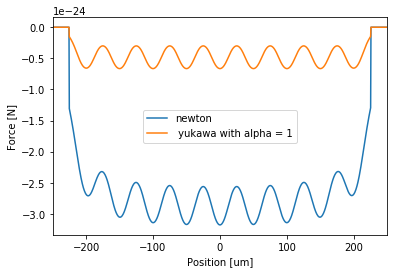

In [280]:
# let's have a look at the force in the spatial dimension

plt.plot(1e6*pos_x,force_x, label = "newton")
plt.plot(1e6*pos_x,force_x_yuk, label = " yukawa with alpha = %d" %alpha)
plt.ylabel("Force [N]")
plt.yticks()
plt.xlabel("Position [um]")
plt.xticks()
plt.xlim(-250,250)
plt.legend()


(array([-300., -200., -100.,    0.,  100.,  200.,  300.]),
 <a list of 7 Text yticklabel objects>)

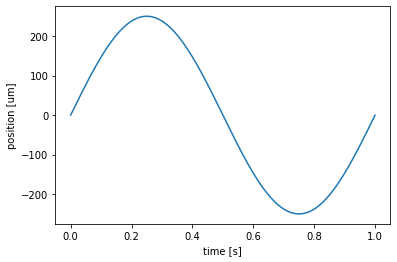

In [281]:
# check the movement profile

plt.plot(time,1e6*osci_pos_func(time=time,frequency=1,stroke=500e-6))
plt.xlabel("time [s]")
plt.xticks()
plt.ylabel("position [um]")
plt.yticks()

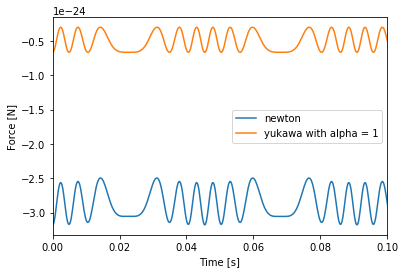

In [306]:
# now force as a function of time

plt.plot(time,osci_force_func(300e-6,time,11,pos_x,force_x), label="newton")
plt.plot(time,osci_force_func(300e-6,time,11,pos_x,force_x_yuk), label =  "yukawa with alpha = %d" %alpha)
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.xlim(0,0.1)
plt.legend()

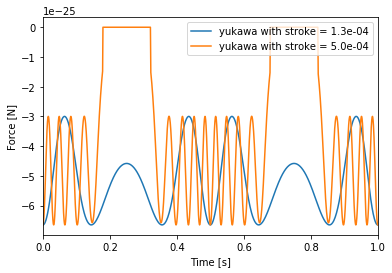

In [283]:
# now force as a function of time with different strokes

stroke1=127e-6
stroke2=500e-6
plt.plot(time,osci_force_func(stroke1,time,1,pos_x,force_x_yuk), label =  "yukawa with stroke = %2.1e" %stroke1)
plt.plot(time,osci_force_func(stroke2,time,1,pos_x,force_x_yuk), label =  "yukawa with stroke = %2.1e" %stroke2)
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.xlim(0,1)
plt.legend()

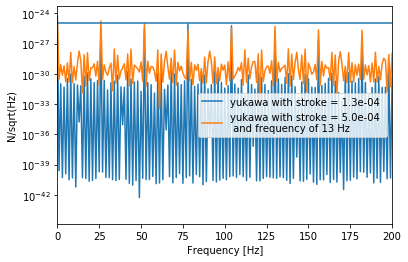

In [284]:
## lets move to the amplitude spectral density 

frequency = 13
psd_dat1,freq1 = psd(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk), 
                   NFFT=len(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk)), Fs=5000, detrend="none",
        window=mlab.window_none, noverlap=0, pad_to=None)

psd_dat2,freq2 = psd(osci_force_func(stroke2,time,frequency,pos_x,force_x_yuk),
                     NFFT=len(osci_force_func(stroke2,time,frequency,pos_x,force_x_yuk)),Fs=5000, detrend="none",
        window=mlab.window_none, noverlap=0, pad_to=None)

plt.plot(freq1,np.sqrt(psd_dat1),label =  "yukawa with stroke = %2.1e" %stroke1)
plt.plot(freq2,np.sqrt(psd_dat2),alpha=1,label =  "yukawa with stroke = %2.1e \n and frequency of %d Hz" %(stroke2,frequency))
plt.yscale("log")
#plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.xlim(0,200)
plt.axhline(1e-25)
#plt.ylim(1e-31,1e-23)
plt.ylabel("N/sqrt(Hz)")
plt.legend()
#plt.xscale("log")

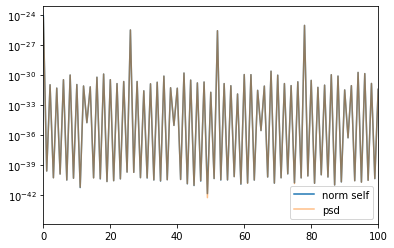

In [285]:
### for cross checks implemented a complementary way to calculate the spectral densities

fft = np.abs(np.fft.rfft(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk)))
freq0 = np.fft.rfftfreq(5000, d=1./5000)
psd_dat0 = fft*fft.conj().real*fft_norm(len(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk)),5000)**2


plt.plot(freq0,np.sqrt(psd_dat0), label = "norm self")
plt.plot(freq1,np.sqrt(psd_dat1), label="psd", alpha =0.5)
plt.yscale("log")
plt.xlim(0,100)
plt.legend()
plt.show()

In [286]:
def complex_plane_func(stroke1,time,frequency,pos_x,force_x_yuk):
    x_val = np.fft.rfft(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk))
    x_val_psd = fft_norm(len(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk)),5000)**2 * (x_val * x_val.conj()).real
    x_val_nsd=np.sqrt(x_val_psd)
    #x_val_phase = np.arctan(x_val.imag/x_val.real)
    x_val_phase2 = np.angle(x_val)
    
    a = x_val_nsd * np.cos(x_val_phase2) 
    b = x_val_nsd * np.sin(x_val_phase2)
    return a,b

In [287]:
a,b = complex_plane_func(stroke1,time,frequency,pos_x,force_x_yuk)

In [288]:
a_list=[]
b_list=[]
for harmonics in np.arange(13,1300,13):
    a_list.append(a[harmonics])
    b_list.append(b[harmonics])

In [289]:
a[26]
#b[26]

3.1185775986762615e-26

Text(0, 0.5, 'Imaginary b')

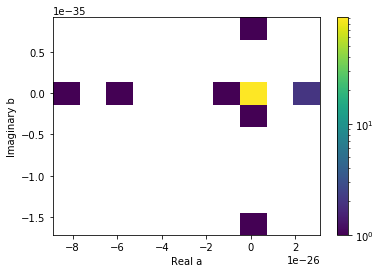

In [299]:
import matplotlib.colors
from matplotlib.colors import LogNorm

plt.hist2d(a_list,b_list,norm=matplotlib.colors.LogNorm(),cmap=matplotlib.cm.viridis)
plt.colorbar()
plt.xlabel("Real a")
plt.ylabel("Imaginary b")
#plt.text(-0.5e-35,1e-26,"Preliminary")

Text(0, 0.5, 'Real a')

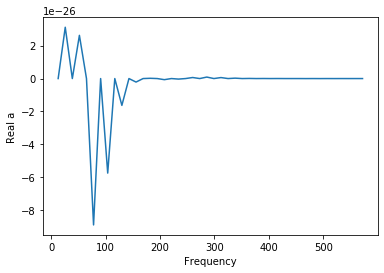

In [303]:
harmonics_phase = np.arange(13,585,13)
plt.plot(harmonics_phase,a[harmonics_phase])
plt.xlabel("Frequency")
plt.ylabel("Real a")
#plt.yscale("log")

Text(0, 0.5, 'Imaginary b')

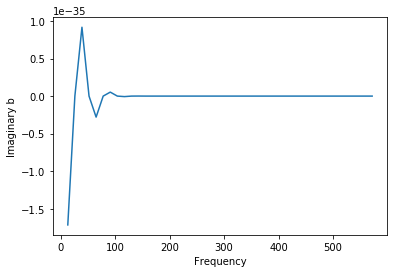

In [305]:
harmonics_phase = np.arange(13,585,13)
plt.plot(harmonics_phase,b[harmonics_phase])
plt.xlabel("Frequency")
plt.ylabel("Imaginary b")

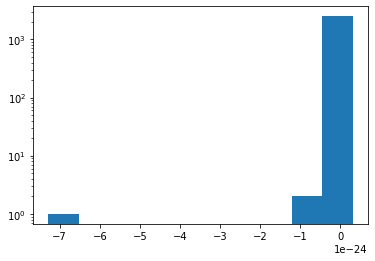

In [142]:
plt.hist(a)
plt.yscale("log")


In [136]:
x_val_phase[26]
x_val_nsd[26]

3.1185775986762607e-25

In [102]:
real = np.real(np.fft.rfft(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk)))
img = np.imag(np.fft.rfft(osci_force_func(stroke1,time,frequency,pos_x,force_x_yuk)))
real_img_phase = np.angle(img/real)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.57612150e-20, -2.54925771e-20, -2.52239391e-20, -2.49553011e-20,
        -2.46866631e-20, -2.44180251e-20, -2.41493871e-20, -2.38807491e-20,
        -2.36121111e-20, -2.33434732e-20, -2.30748352e-20, -2.28061972e-20,
        -2.25375592e-20, -2.22689212e-20, -2.20002832e-20, -2.17316452e-20,
        -2.14630072e-20, -2.11943693e-20, -2.09257313e-20, -2.06570933e-20,
        -2.03884553e-20, -2.01198173e-20, -1.98511793e-20, -1.95825413e-20,
        -1.93139033e-20, -1.90452654e-20, -1.87766274e-20, -1.85079894e-20,
        -1.82393514e-20, -1.79707134e-20, -1.77020754e-20, -1.74334374e-20,
        -1.71647995e-20, -1.68961615e-20, -1.66275235e-20, -1.63588855e-20,
        -1.60902475e-20, -1.58216095e-20, -1.55529715e-20, -1.52843

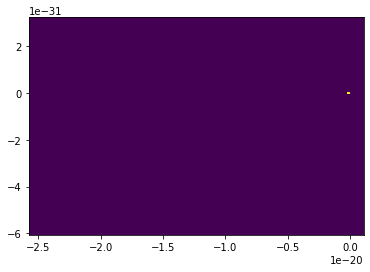

In [58]:
plt.hist2d(real,img,bins=(100,100))
#plt.yscale("log")
#plt.xscale("log")

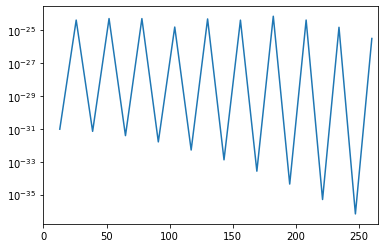

(3.783430423242037e-24,
 array([ 13,  26,  39,  52,  65,  78,  91, 104, 117, 130, 143, 156, 169,
        182, 195, 208, 221, 234, 247, 260]),
 [9.622433494102581e-32,
  4.127805561172342e-25,
  7.101718713876121e-32,
  5.109944623585801e-25,
  3.9028320209877917e-32,
  5.079781285423884e-25,
  1.6226457632665952e-32,
  1.5544171349029266e-25,
  5.207723917585886e-33,
  4.838019841529238e-25,
  1.3187813256571246e-33,
  4.090961913214037e-25,
  2.689424628687159e-34,
  7.0652214404523175e-25,
  4.4355889626968825e-35,
  4.148314557060263e-25,
  5.0989707091736325e-36,
  1.5055796759201613e-25,
  6.787629108421164e-37,
  3.142559057405888e-26],
 [-1.5707963356102688,
  -3.14159265358979,
  1.5707963262986,
  2.4080028225883007e-15,
  -1.5707963279283785,
  -3.1415926535897927,
  1.5707962864293232,
  5.504036204736812e-15,
  -1.5707961495026703,
  4.912721414170335e-15,
  1.5707955534078981,
  -3.141592653589789,
  -1.5707929859454797,
  -3.141592653589788,
  1.5708169695985033,
  -3.141

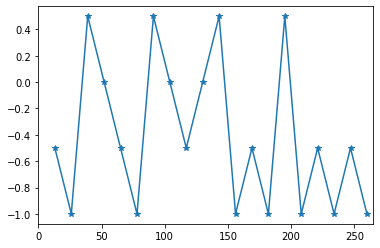

In [13]:
function_response_2(1,1,5000,pos_x,force_x_yuk,250e-6,13,20,bkg=False,plot=True)


1.0334506489914483e-18


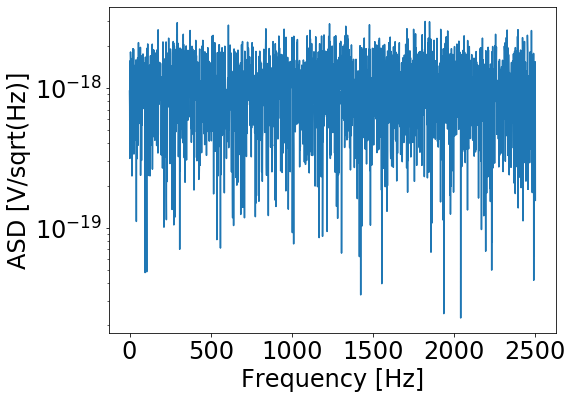

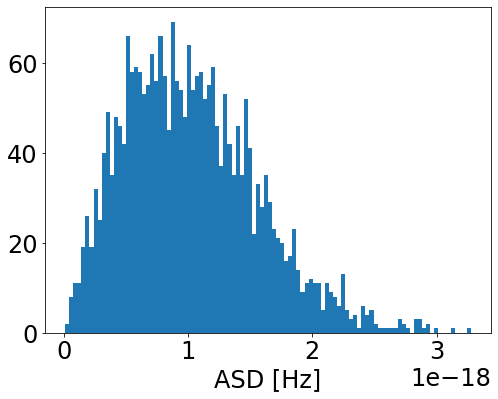

1.7279873341025388e-18


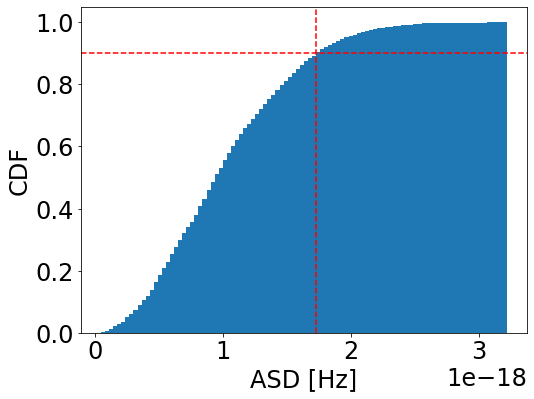

In [51]:
# generate noise fft with an idealized value
noise_floor = 1.85*np.pi*1e-17

plt.plot(freq1,np.sqrt(generate_white_noise(5000,5000,noise_floor)[0]))
print(np.mean(np.sqrt(generate_white_noise(5000,5000,noise_floor)[0])))
plt.yscale("log")
plt.ylabel("ASD [V/sqrt(Hz)]")
plt.xlabel("Frequency [Hz]")
plt.show()

plt.hist(np.sqrt(generate_white_noise(5000,5000,noise_floor)[0]), bins =100)
plt.xlabel("ASD [Hz]")
plt.show()

print(fraction_of_histo(np.sqrt(generate_white_noise(5000,5000,noise_floor)[0]),bins=100,intervall=0.9))


In [12]:
def measurement_response(alpha,int_time,fs,pos_vec,force_vec,stroke,frequency,noise_floor,no_harmonics,plot,manual):
    force_vec = force_vec * alpha # scale the force vector by alpha
    time = np.arange(0,int_time,1/sampling_frequency) # make a time array, default 1s
    length = len(osci_force_func(stroke,time,frequency,pos_vec,force_vec)) # length of the array
    #noise_floor = 1.85*np.pi*1e-17
    signal = osci_force_func(stroke,time,frequency,pos_x,force_vec)
    noise = noise_floor  * np.random.randn(length)
    background = 0 # implement later
    measurement = noise + signal + background
    
    
    # calculate the psd "manually"
    fft = np.abs(np.fft.rfft(measurement)) 
    freq = np.fft.rfftfreq(length, d=1./fs)
    psd_dat1 = fft*fft.conj().real*fft_norm(length,fs)**2
    
    # let mlab do the job
    psd_dat2,freq2 = psd(measurement, 
                         NFFT=length, 
                         Fs=fs, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    response =0
    if(plot==True):
        plt.plot(freq2,np.sqrt(psd_dat2))
        plt.yscale("log")
        plt.xlim(0,np.max(no_harmonics)*frequency)
    for i in no_harmonics:
        if(manual==True):
            response+=psd_dat1[i*frequency]
        if(manual==False):    
            response+=psd_dat2[i*frequency]
        #print(response,i*frequency)
    return response

In [13]:
def measurement_response_harmonics(alpha,int_time,fs,pos_vec,force_vec,stroke,frequency,noise_floor,no_harmonics,plot,manual):
    force_vec = force_vec * alpha # scale the force vector by alpha
    time = np.arange(0,int_time,1/sampling_frequency) # make a time array, default 1s
    length = len(osci_force_func(stroke,time,frequency,pos_vec,force_vec)) # length of the array
    #noise_floor = 1.85*np.pi*1e-17
    signal = osci_force_func(stroke,time,frequency,pos_x,force_vec)
    noise = noise_floor  * np.random.randn(length)
    background = 0 # implement later
    measurement = noise + signal + background
    
    
    # calculate the psd "manually"
    fft = np.abs(np.fft.rfft(measurement)) 
    freq = np.fft.rfftfreq(length, d=1./fs)
    psd_dat1 = fft*fft.conj().real*fft_norm(length,fs)**2
    
    # let mlab do the job
    psd_dat2,freq2 = psd(measurement, 
                         NFFT=length, 
                         Fs=fs, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
    response = []
    if(plot==True):
        plt.plot(freq2,np.sqrt(psd_dat2))
        plt.yscale("log")
        plt.xlim(0,np.max(no_harmonics)*frequency)
    for i in no_harmonics:
        if(manual==True):
            response.append(psd_dat1[i*frequency])
        if(manual==False):    
            response.append(psd_dat2[i*frequency])
        #print(response,i*frequency)
    return response

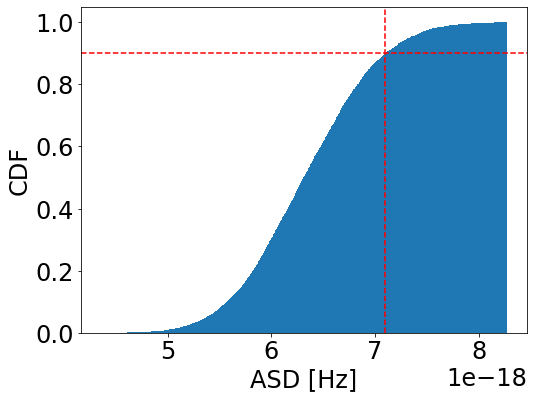

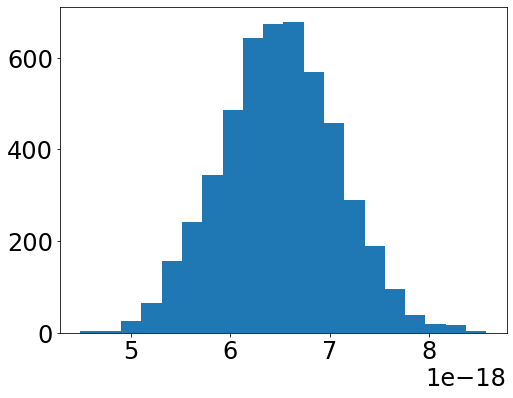

7.09984248494322e-18 alpha: 3.00e+06 6.492274907240479e-18


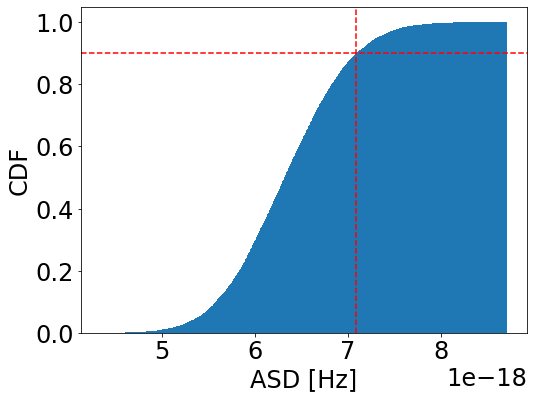

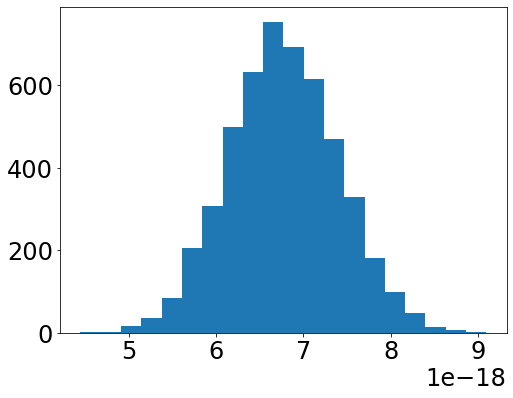

7.091796508710789e-18 alpha: 4.75e+06 6.773790020064295e-18


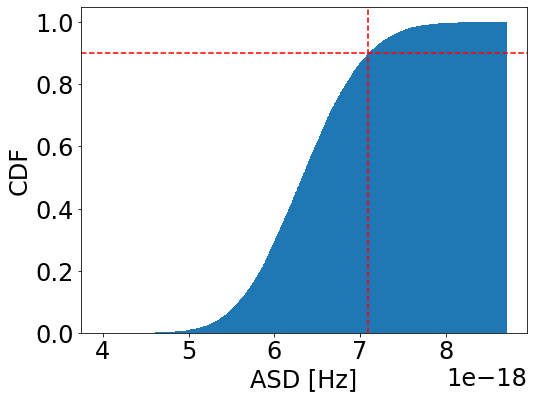

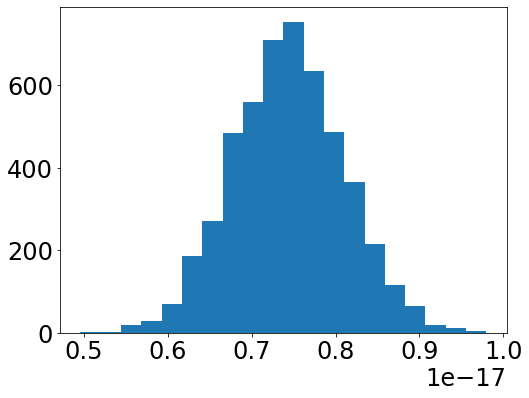

7.09857332820428e-18 alpha: 7.54e+06 7.434872529116094e-18


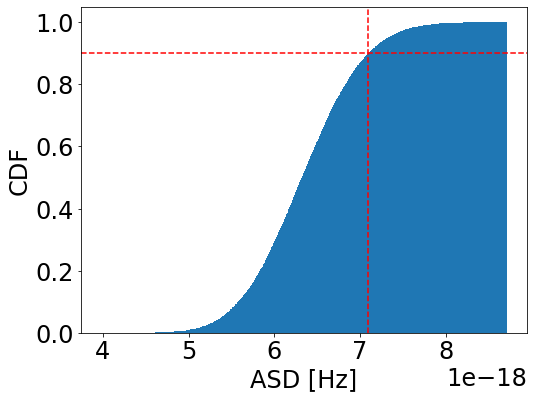

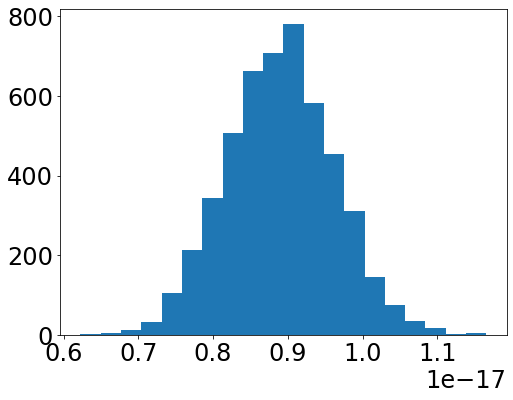

7.09383927372698e-18 alpha: 1.19e+07 8.90049333283641e-18


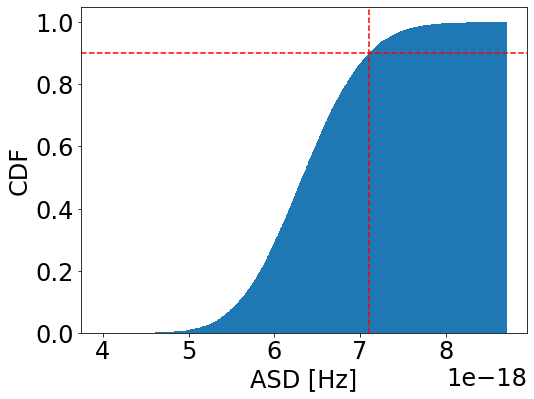

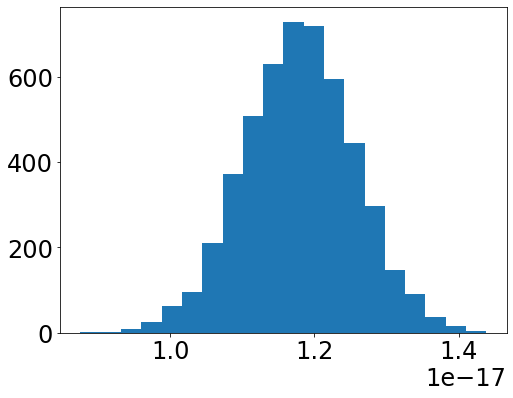

7.103307382681578e-18 alpha: 1.89e+07 1.1787893931449402e-17


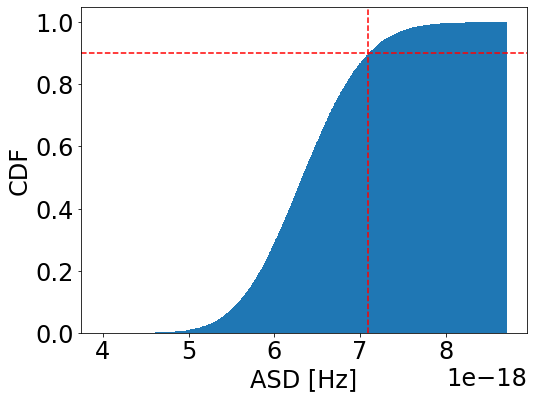

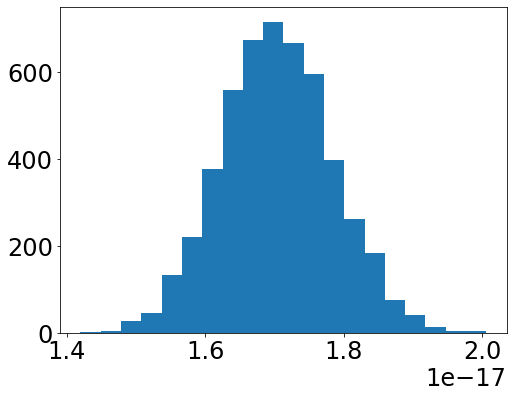

7.09857332820428e-18 alpha: 3.00e+07 1.7038237054020225e-17


In [741]:
noise_floor = 1.85*np.pi*1e-17
no_harmonics = np.arange(0,30,1)
frequency = 13
noise_response_list=[]
#
#print(re/limit, re)
#plt.plot(freq,np.sqrt(generate_white_noise(5000,5000,noise_floor)[0]))
for alpha in np.geomspace(3e06,3e07,6):
    response_list=[]
    for k in np.arange(0,5000):    
        noise_response_list.append(noise_response(no_harmonics,frequency,noise_floor))
        response_list.append(measurement_response(alpha=alpha,int_time=1,fs=5000,pos_vec=pos_x,force_vec=force_x_yuk,stroke=500e-6,frequency=frequency,noise_floor=noise_floor,no_harmonics=no_harmonics,plot=False,manual=False))
    limit = fraction_of_histo(np.sqrt(noise_response_list),bins=1000,intervall=0.9)
    #plt.hist(np.sqrt(noise_response_list),bins=20)
    plt.hist(np.sqrt(response_list),bins=20)
    plt.show()
    print(limit,"alpha: %2.2e" %alpha,np.mean(np.sqrt(response_list)))

In [742]:
2.00e+07/np.sqrt(1e5)
7.54e+06/np.sqrt(1e5)

23843.573557669577

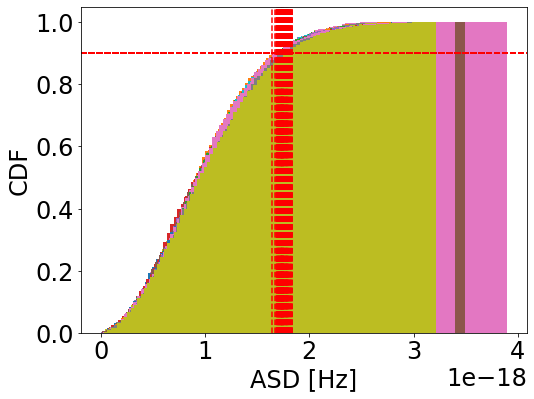

In [41]:
no_harmonics = np.arange(1,100,1)
noise_resp_list=[]
limit_list=[]
noise_resp_per_harmonic =0
for k in np.arange(0,1000,1):    
    noise_resp_list.append(noise_response_per_harmonics(no_harmonics,frequency,noise_floor))
noise_resp_per_harmonic = np.stack(np.sqrt(noise_resp_list), axis=1)
for j in no_harmonics-1:
    limit_list.append(fraction_of_histo(noise_resp_per_harmonic[j],bins=100,intervall=0.9))
cumsum_signal =[]
cumsum_noise = np.cumsum(limit_list)    

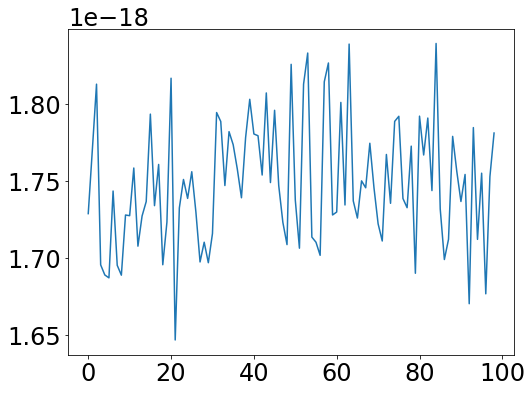

In [42]:
plt.plot(limit_list)

In [355]:
no_harmonics = np.arange(1,100,1)
alpha_list=[]
signal_list=[]
for alpha in tqdm(np.geomspace(1e05,1e14,90)):
        response_list=[]
        alpha_list.append(alpha)
        for k in np.arange(0,1000,1):
            response_list.append(measurement_response_harmonics(alpha=alpha,int_time=1,fs=5000,pos_vec=pos_x,force_vec=force_x_yuk,stroke=500e-6,frequency=frequency,noise_floor=noise_floor,no_harmonics=no_harmonics,plot=False,manual=False))
        signal_resp_per_harmonic = np.stack(np.sqrt(response_list), axis=1)
        for i in np.arange(0,99,1):
            signal_list.append(np.mean(signal_resp_per_harmonic[i]))
signal_list = np.reshape(signal_list,(90,99))






  0%|          | 0/90 [00:00<?, ?it/s]



  1%|          | 1/90 [00:00<01:10,  1.26it/s]



  2%|▏         | 2/90 [00:01<01:09,  1.26it/s]



  3%|▎         | 3/90 [00:02<01:09,  1.25it/s]



  4%|▍         | 4/90 [00:03<01:08,  1.25it/s]



  6%|▌         | 5/90 [00:03<01:07,  1.25it/s]



  7%|▋         | 6/90 [00:04<01:07,  1.25it/s]



  8%|▊         | 7/90 [00:05<01:06,  1.25it/s]



  9%|▉         | 8/90 [00:06<01:05,  1.26it/s]



 10%|█         | 9/90 [00:07<01:04,  1.25it/s]



 11%|█         | 10/90 [00:07<01:03,  1.25it/s]



 12%|█▏        | 11/90 [00:08<01:03,  1.25it/s]



 13%|█▎        | 12/90 [00:09<01:02,  1.25it/s]



 14%|█▍        | 13/90 [00:10<01:01,  1.26it/s]



 16%|█▌        | 14/90 [00:11<01:00,  1.25it/s]



 17%|█▋        | 15/90 [00:11<00:59,  1.25it/s]



 18%|█▊        | 16/90 [00:12<00:58,  1.26it/s]



 19%|█▉        | 17/90 [00:13<00:58,  1.25it/s]



 20%|██        | 18/90 [00:14<00:57,  1.25it/s]



 21%|██        | 19/90 [00:15<00:56,  1.25it/

Text(0.5, 1.0, 'alpha = 3.55E+09')

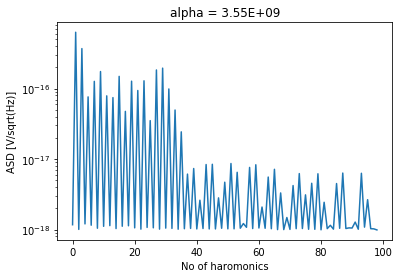

In [360]:
plt.plot(np.arange(0,len(signal_list[45]),1),signal_list[45])
plt.yscale("log")
plt.xlabel("No of haromonics")
plt.ylabel("ASD [V/sqrt(Hz)]")
plt.title("alpha = %2.2E" % alpha_list[45])

In [361]:
cumsum_signal =[]
for alpha in np.arange(0,len(alpha_list),1):
    cumsum_signal.append(np.cumsum(signal_list[alpha]))
    
    

Text(0.5, 0, 'summed harmonics')

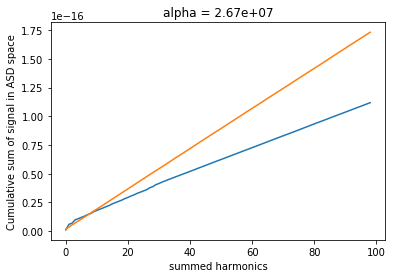

In [364]:
plt.plot(cumsum_signal[24])
plt.plot(cumsum_noise)
plt.title("alpha = %2.2e" % alpha_list[24])
plt.ylabel("Cumulative sum of signal in ASD space")
plt.xlabel("summed harmonics")

In [ ]:
### x = np.arange(0,10,1)
plt.plot(x,alpha_list)
plt.xlabel("Number of harmonics")
plt.ylabel("alpha")

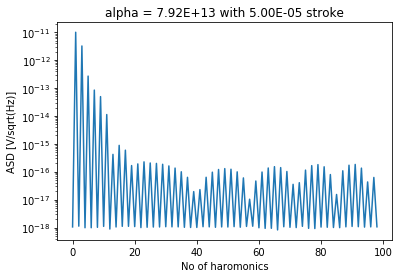

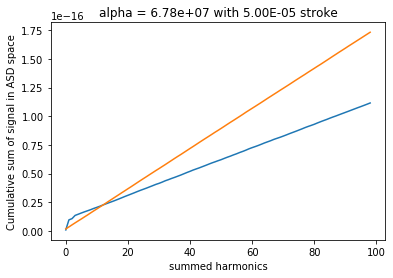

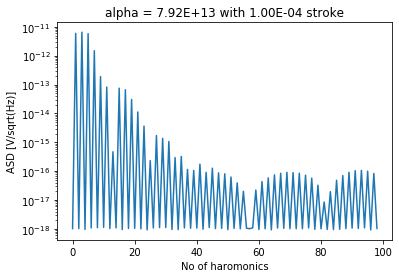

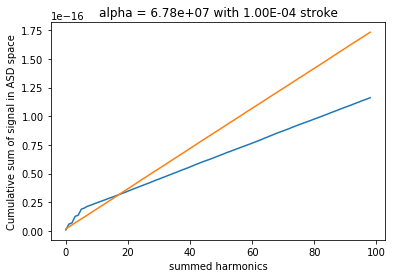

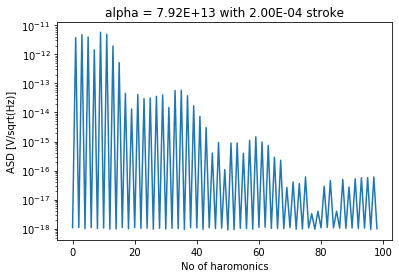

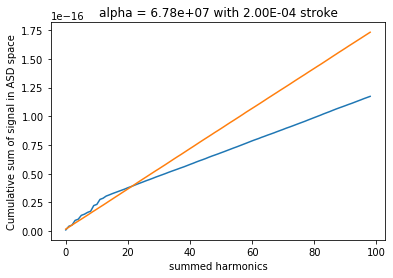

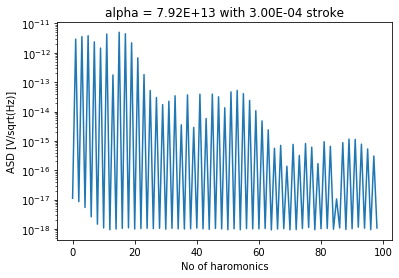

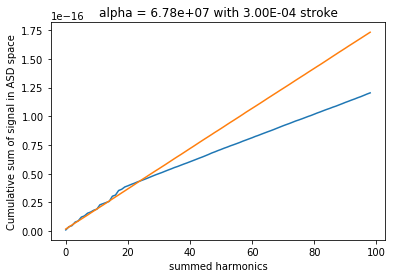

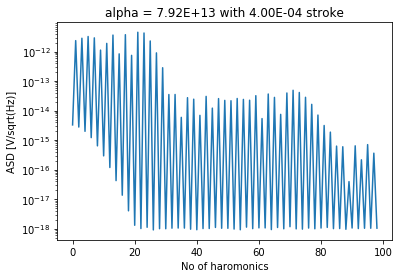

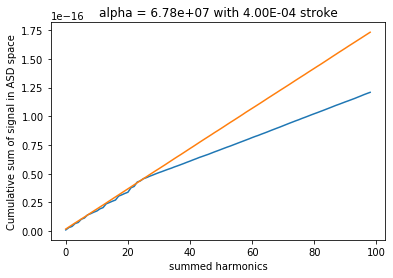

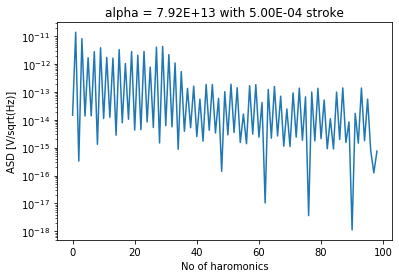

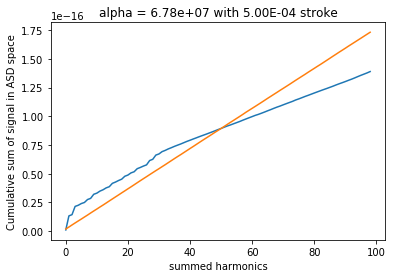

In [367]:
# check sensitivity alpha as a function of stroke

no_harmonics = np.arange(1,100,1)

for stroke in [50e-6,100e-6,200e-6,300e-6,400e-6,500e-6]:
    signal_list=[]
    alpha_list=[]
    for alpha in np.geomspace(1e05,1e14,90):
            response_list=[]
            signal_resp_per_harmonic = 0
            alpha_list.append(alpha)
            for k in np.arange(0,100,1):
                response_list.append(measurement_response_harmonics(alpha=alpha,int_time=1,fs=5000,pos_vec=pos_x,force_vec=force_x_yuk,stroke=stroke,frequency=frequency,noise_floor=noise_floor,no_harmonics=no_harmonics,plot=False,manual=False))
            signal_resp_per_harmonic = np.stack(np.sqrt(response_list), axis=1)
            for i in np.arange(0,99,1):
                signal_list.append(np.mean(signal_resp_per_harmonic[i]))
    signal_list = np.reshape(signal_list,(90,99))
    
    cumsum_signal=[]
    for alpha in np.arange(0,len(alpha_list),1):
        cumsum_signal.append(np.cumsum(signal_list[alpha]))

    folder = "Results/"
    file1 = "Harmonics_%2.2E_%2.2E" % ((alpha_list[88],stroke))
    plt.plot(np.arange(0,len(signal_list[88]),1),signal_list[88])
    plt.yscale("log")
    plt.xlabel("No of haromonics")
    plt.ylabel("ASD [V/sqrt(Hz)]")
    plt.title("alpha = %2.2E with %2.2E stroke" % (alpha_list[88],stroke))
    plt.savefig(folder+file1+".png",dpi=300)
    plt.show()

    file2="Cumsum_%2.2E_%2.2E" % ((alpha_list[28],stroke))
    plt.plot(cumsum_signal[28])
    plt.plot(cumsum_noise)
    plt.title("alpha = %2.2e with %2.2E stroke" % (alpha_list[28],stroke))
    plt.ylabel("Cumulative sum of signal in ASD space")
    plt.xlabel("summed harmonics")
    plt.savefig(folder+file2+".png",dpi=300)
    plt.show()



In [403]:
## increase the beadsize

## load the data dictionary file (its usually of the form results_dic[rbead][sep][height][yuklambda])

res_dict_side_by_side = pkl.load( open('/home/analysis_user/Results/Sensitivity/rbead_7.2e-06_sep_7.5e-06_height_0.p', 'rb'))
separation = 7.5e-6 # separation is set by the file you load TODO automatize
lambda_par= 1e-5 # pick a lambda parameter
force_x = res_dict_side_by_side[7.2e-6][separation][0][lambda_par][0] # force in direction of the sphere
force_x_yuk = alpha*res_dict_side_by_side[7.2e-6][separation][0][lambda_par][3] # force by the yukawa potential
pos_x = res_dict_side_by_side["posvec"] # get the position of the bead from the dictionary



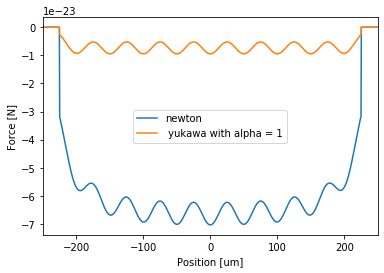

In [404]:
# let's have a look at the force in the spatial dimension

plt.plot(1e6*pos_x,force_x, label = "newton")
plt.plot(1e6*pos_x,force_x_yuk, label = " yukawa with alpha = %d" %alpha)
plt.ylabel("Force [N]")
plt.yticks()
plt.xlabel("Position [um]")
plt.xticks()
plt.xlim(-250,250)
plt.legend()


In [377]:
no_harmonics = np.arange(1,100,1)
alpha_list=[]
signal_list=[]
for alpha in tqdm(np.geomspace(1e02,1e11,90)):
        response_list=[]
        alpha_list.append(alpha)
        for k in np.arange(0,1000,1):
            response_list.append(measurement_response_harmonics(alpha=alpha,int_time=1,fs=5000,pos_vec=pos_x,force_vec=force_x_yuk,stroke=500e-6,frequency=frequency,noise_floor=noise_floor,no_harmonics=no_harmonics,plot=False,manual=False))
        signal_resp_per_harmonic = np.stack(np.sqrt(response_list), axis=1)
        for i in np.arange(0,99,1):
            signal_list.append(np.mean(signal_resp_per_harmonic[i]))
signal_list = np.reshape(signal_list,(90,99))






  0%|          | 0/90 [00:00<?, ?it/s]



  1%|          | 1/90 [00:00<01:10,  1.26it/s]



  2%|▏         | 2/90 [00:01<01:09,  1.26it/s]



  3%|▎         | 3/90 [00:02<01:09,  1.25it/s]



  4%|▍         | 4/90 [00:03<01:09,  1.24it/s]



  6%|▌         | 5/90 [00:04<01:08,  1.24it/s]



  7%|▋         | 6/90 [00:04<01:07,  1.24it/s]



  8%|▊         | 7/90 [00:05<01:06,  1.24it/s]



  9%|▉         | 8/90 [00:06<01:05,  1.24it/s]



 10%|█         | 9/90 [00:07<01:05,  1.25it/s]



 11%|█         | 10/90 [00:08<01:04,  1.25it/s]



 12%|█▏        | 11/90 [00:08<01:03,  1.25it/s]



 13%|█▎        | 12/90 [00:09<01:02,  1.25it/s]



 14%|█▍        | 13/90 [00:10<01:01,  1.25it/s]



 16%|█▌        | 14/90 [00:11<01:00,  1.25it/s]



 17%|█▋        | 15/90 [00:12<01:00,  1.25it/s]



 18%|█▊        | 16/90 [00:12<00:59,  1.25it/s]



 19%|█▉        | 17/90 [00:13<00:58,  1.25it/s]



 20%|██        | 18/90 [00:14<00:57,  1.25it/s]



 21%|██        | 19/90 [00:15<00:56,  1.25it/

Text(0.5, 1.0, 'alpha = 7.92E+10')

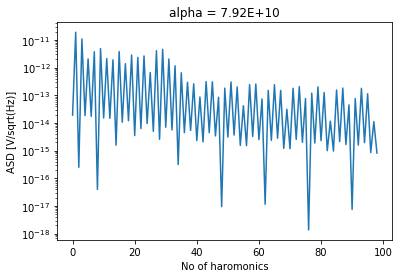

In [381]:
plt.plot(np.arange(0,len(signal_list[88]),1),signal_list[88])
plt.yscale("log")
plt.xlabel("No of haromonics")
plt.ylabel("ASD [V/sqrt(Hz)]")
plt.title("alpha = %2.2E" % alpha_list[88])

In [382]:
cumsum_signal =[]
for alpha in np.arange(0,len(alpha_list),1):
    cumsum_signal.append(np.cumsum(signal_list[alpha]))
    
    

Text(0.5, 0, 'summed harmonics')

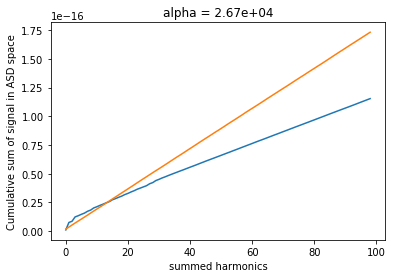

In [384]:
plt.plot(cumsum_signal[24])
plt.plot(cumsum_noise)
plt.title("alpha = %2.2e" % alpha_list[24])
plt.ylabel("Cumulative sum of signal in ASD space")
plt.xlabel("summed harmonics")

In [385]:
## increase the beadsize

## load the data dictionary file (its usually of the form results_dic[rbead][sep][height][yuklambda])

res_dict_side_by_side = pkl.load(open('/home/analysis_user/Results/Sensitivity/rbead_7.2e-06_sep_2.5e-06_height_0.p', 'rb'))
separation = 2.5e-6 # separation is set by the file you load TODO automatize
lambda_par= 1e-5 # pick a lambda parameter
force_x = res_dict_side_by_side[7.2e-6][separation][0][lambda_par][0] # force in direction of the sphere
force_x_yuk = alpha*res_dict_side_by_side[7.2e-6][separation][0][lambda_par][3] # force by the yukawa potential
pos_x = res_dict_side_by_side["posvec"] # get the position of the bead from the dictionary



In [386]:
no_harmonics = np.arange(1,100,1)
alpha_list=[]
signal_list=[]
for alpha in tqdm(np.geomspace(1e02,1e11,90)):
        response_list=[]
        alpha_list.append(alpha)
        for k in np.arange(0,1000,1):
            response_list.append(measurement_response_harmonics(alpha=alpha,int_time=1,fs=5000,pos_vec=pos_x,force_vec=force_x_yuk,stroke=500e-6,frequency=frequency,noise_floor=noise_floor,no_harmonics=no_harmonics,plot=False,manual=False))
        signal_resp_per_harmonic = np.stack(np.sqrt(response_list), axis=1)
        for i in np.arange(0,99,1):
            signal_list.append(np.mean(signal_resp_per_harmonic[i]))
signal_list = np.reshape(signal_list,(90,99))






  0%|          | 0/90 [00:00<?, ?it/s]



  1%|          | 1/90 [00:00<01:10,  1.25it/s]



  2%|▏         | 2/90 [00:01<01:10,  1.25it/s]



  3%|▎         | 3/90 [00:02<01:09,  1.25it/s]



  4%|▍         | 4/90 [00:03<01:09,  1.24it/s]



  6%|▌         | 5/90 [00:04<01:08,  1.24it/s]



  7%|▋         | 6/90 [00:04<01:07,  1.24it/s]



  8%|▊         | 7/90 [00:05<01:06,  1.25it/s]



  9%|▉         | 8/90 [00:06<01:05,  1.24it/s]



 10%|█         | 9/90 [00:07<01:05,  1.25it/s]



 11%|█         | 10/90 [00:08<01:04,  1.25it/s]



 12%|█▏        | 11/90 [00:08<01:03,  1.25it/s]



 13%|█▎        | 12/90 [00:09<01:02,  1.25it/s]



 14%|█▍        | 13/90 [00:10<01:01,  1.25it/s]



 16%|█▌        | 14/90 [00:11<01:01,  1.25it/s]



 17%|█▋        | 15/90 [00:12<01:00,  1.24it/s]



 18%|█▊        | 16/90 [00:12<00:59,  1.24it/s]



 19%|█▉        | 17/90 [00:13<00:59,  1.24it/s]



 20%|██        | 18/90 [00:14<00:58,  1.24it/s]



 21%|██        | 19/90 [00:15<00:57,  1.24it/

Text(0.5, 1.0, 'alpha = 7.92E+10')

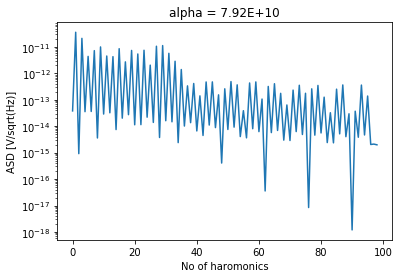

In [387]:
plt.plot(np.arange(0,len(signal_list[88]),1),signal_list[88])
plt.yscale("log")
plt.xlabel("No of haromonics")
plt.ylabel("ASD [V/sqrt(Hz)]")
plt.title("alpha = %2.2E" % alpha_list[88])

In [388]:
cumsum_signal =[]
for alpha in np.arange(0,len(alpha_list),1):
    cumsum_signal.append(np.cumsum(signal_list[alpha]))
    

Text(0.5, 0, 'summed harmonics')

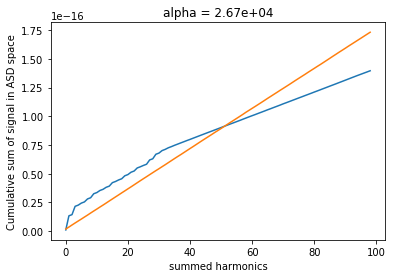

In [392]:
plt.plot(cumsum_signal[24])
plt.plot(cumsum_noise)
plt.title("alpha = %2.2e" % alpha_list[24])
plt.ylabel("Cumulative sum of signal in ASD space")
plt.xlabel("summed harmonics")

In [14]:
# take noise floor of real data and compare sensitvity

# load the data
Day = "17"
Month = "07"
Year = "2019"
BeadNumber = 5
#RunNumber = 144
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day +"/Bead"+str(BeadNumber)+"/NoiseFluctuation/"
files = load_dir(folder, file_prefix = 'Discharge', max_file=500)

Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinning data
Error loading spinni

In [15]:
x2_reshaped = {}
for i in np.arange(0,50):
    x2_reshaped[i] = np.reshape(files[i].x2,(120,5000))

In [16]:
norm_val = 4.15e-17
norm_freq = 151
norm_mean = 2.8382988866248244e-06
psd_from_data = {}
total_reshape_list=[]
p=0
for j in np.arange(0,50,1):
    for i in np.arange(0,120,1):
        psd_from_data[i],freq_data = psd(x2_reshaped[j][i],NFFT=5000,Fs=5000, detrend="none",window=mlab.window_none, noverlap=0, pad_to=None)
        total_reshape_list.append(psd_from_data[i])
        #norm_mean += np.sqrt(psd_from_data[i][121])
#print(norm_mean/(10*120))        
        '''
        plt.plot(freq_data,norm_val/norm_mean*np.sqrt(psd_from_data[i]))
        plt.axhline(norm_val)
        plt.yscale("log")
        plt.xlim(20,200)  
        plt.ylim(1e-19,1e-14)
        plt.xlabel("frequency")
        plt.ylabel("ASD [V/sqrt(HZ)]")
        '''

In [17]:
convert_to_freq_stack = np.stack(total_reshape_list,axis=1)
normed_ASD = np.sqrt(convert_to_freq_stack)*norm_val/norm_mean


13


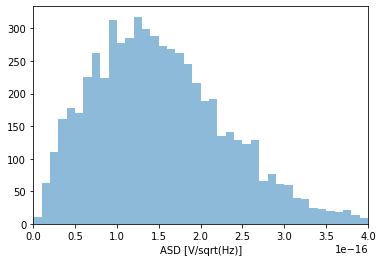

In [18]:
print(frequency)
for no_harmonics in np.arange(14,15,1):
    response_real_noise = []
    for j in np.arange(0,len(normed_ASD[0]),1):
        response_sum=0
        #for i in no_harmonics:
        response_sum += normed_ASD[no_harmonics*frequency][j]
        response_real_noise.append(response_sum) 
    #fraction_of_histo(input_histo=(response_real_noise),bins=50,intervall=0.9)
    plt.hist(response_real_noise,range=[0,1e-15],bins=100, alpha = 0.5)
    plt.xlim(0,0.4e-15)
    plt.xlabel("ASD [V/sqrt(Hz)]")
    #plt.show()

In [ ]:
# take real noise and check sensitivity as a function of harmonics and stroke

no_harmonics = np.arange(1,100,1)
real_noise_response_per_harmonics=[]
limit_list=[]
noise_resp_per_harmonic =0
for j in np.arange(0,len(normed_ASD[0]),1):
        response_sum=0
        for i in no_harmonics:
            real_noise_response_per_harmonics.append(normed_ASD[no_harmonics*frequency][j])


In [ ]:
# take real noise and check sensitivity as a function of movement 

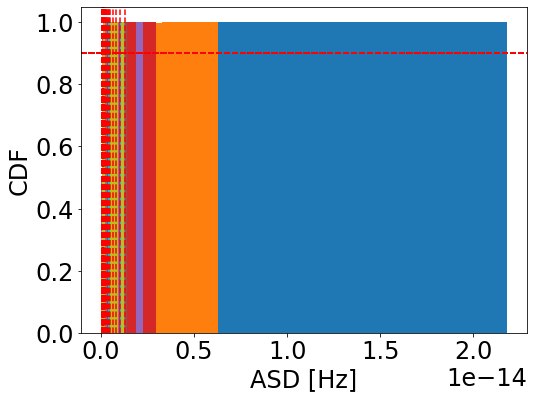

In [43]:
limit_list=[]
no_harmonics = np.arange(1,100,1)
for i in no_harmonics:
    limit_list.append(fraction_of_histo(input_histo=(normed_ASD[i]),bins=50,intervall=0.9))


Text(0, 0.5, 'ASD limit [V/sqrt(Hz)]')

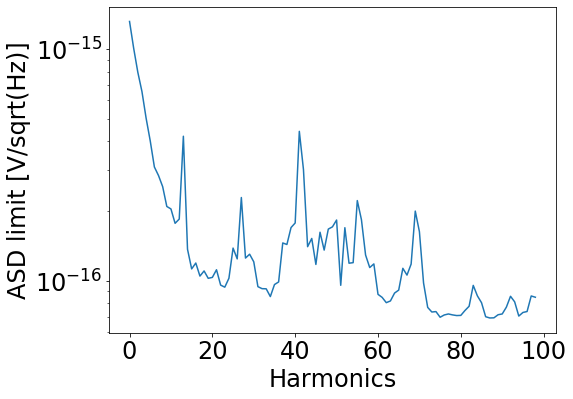

In [44]:
plt.plot(limit_list)
plt.yscale("log")
plt.xlabel("Harmonics")
plt.ylabel("ASD limit [V/sqrt(Hz)]")
#plt.axhline(4e-17)
#plt.axhline(1e-16)

In [56]:
cumsum_signal =[]
cumsum_noise = np.cumsum(limit_list)   

In [79]:
no_harmonics = np.arange(1,100,1)
noise_floor = 44*1.85*np.pi*1e-17
alpha_list=[]
signal_list=[]
for alpha in tqdm(np.geomspace(1e05,1e14,90)):
        response_list=[]
        alpha_list.append(alpha)
        for k in np.arange(0,1000,1):
            response_list.append(measurement_response_harmonics(alpha=alpha,int_time=1,fs=5000,pos_vec=pos_x,force_vec=force_x_yuk,stroke=500e-6,frequency=frequency,noise_floor=noise_floor,no_harmonics=no_harmonics,plot=False,manual=False))
        signal_resp_per_harmonic = np.stack(np.sqrt(response_list), axis=1)
        for i in np.arange(0,99,1):
            signal_list.append(np.mean(signal_resp_per_harmonic[i]))
signal_list = np.reshape(signal_list,(90,99))


100%|██████████| 90/90 [01:11<00:00,  1.26it/s]


In [140]:
np.argmax(signal_list[65][4:-1])

25

Text(0.5, 1.0, 'alpha = 3.55E+09')

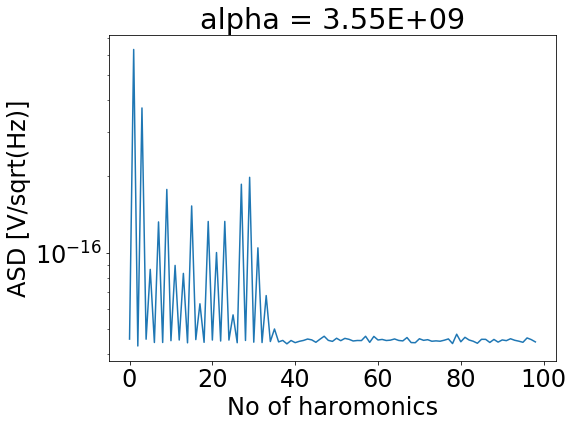

In [80]:
plt.plot(np.arange(0,len(signal_list[65]),1),signal_list[45])
plt.yscale("log")
plt.xlabel("No of haromonics")
plt.ylabel("ASD [V/sqrt(Hz)]")
plt.title("alpha = %2.2E" % alpha_list[45])

In [81]:
cumsum_signal =[]
for alpha in np.arange(0,len(alpha_list),1):
    cumsum_signal.append(np.cumsum(signal_list[alpha]))    

(0, 1e-14)

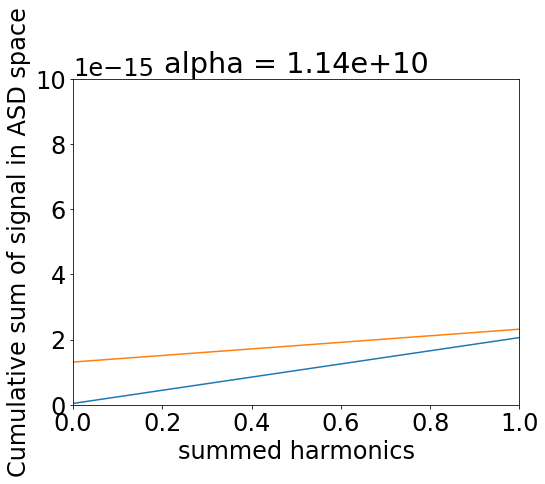

In [118]:
alpha_p = 50
plt.plot(cumsum_signal[alpha_p])
plt.plot(cumsum_noise)
plt.title("alpha = %2.2e" % alpha_list[alpha_p])
plt.ylabel("Cumulative sum of signal in ASD space")
plt.xlabel("summed harmonics")
plt.xlim(0,1)
plt.ylim(0,1e-14)

Text(0.5, 0, 'Harmonics')

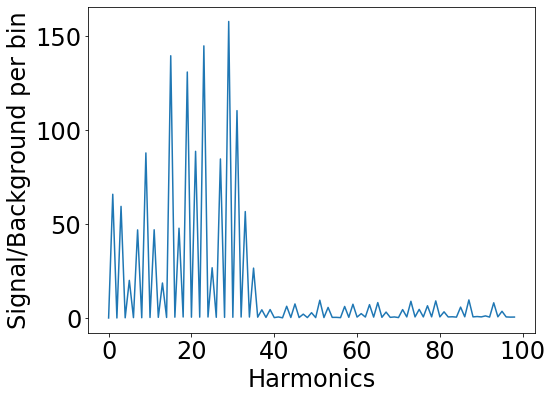

In [210]:
ratio = list(signal_list[65]/limit_list)
#ratio.sort()
maxindex = sorted(range(len(ratio)), key=lambda k: ratio[k], reverse=True)

plt.plot(ratio)
plt.ylabel("Signal/Background per bin")
plt.xlabel("Harmonics")

In [240]:
cum_sum_noise=0
cum_sum_signal_list=[]
for alpha in np.arange(0,len(alpha_list),1):
    cum_sum_signal = 0
    cum_sum_noise=0
    for no_harmonics in [29,23,15,19]:
        cum_sum_noise += limit_list[no_harmonics]
        cum_sum_signal += signal_list[alpha][no_harmonics]
    cum_sum_signal_list.append(cum_sum_signal)

(1000000000.0, 50000000000.0)

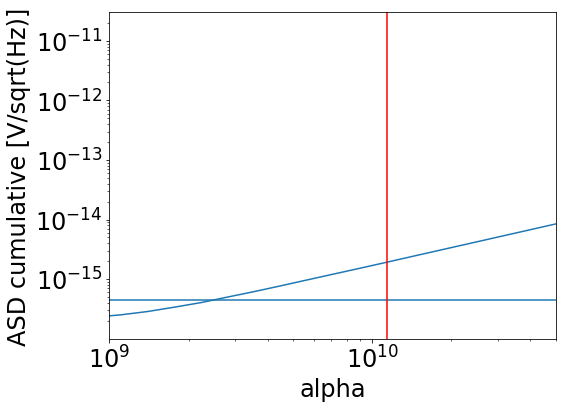

In [242]:
plt.plot(alpha_list,cum_sum_signal_list)
plt.axhline(cum_sum_noise)
plt.axvline(1.14e10, color="red")
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("ASD cumulative [V/sqrt(Hz)]")
plt.yscale("log")
plt.xlim(1e9,5e10)

In [239]:
maxindex

[29,
 23,
 15,
 19,
 31,
 21,
 9,
 27,
 1,
 3,
 33,
 17,
 11,
 7,
 25,
 35,
 5,
 13,
 87,
 51,
 79,
 73,
 65,
 93,
 45,
 59,
 63,
 77,
 43,
 57,
 85,
 53,
 75,
 71,
 39,
 37,
 95,
 81,
 67,
 49,
 61,
 47,
 91,
 89,
 83,
 94,
 86,
 78,
 88,
 80,
 90,
 76,
 96,
 74,
 72,
 82,
 69,
 41,
 18,
 24,
 62,
 32,
 34,
 98,
 92,
 60,
 64,
 97,
 84,
 22,
 36,
 16,
 20,
 30,
 58,
 26,
 66,
 12,
 68,
 55,
 54,
 28,
 38,
 14,
 10,
 44,
 46,
 52,
 70,
 48,
 50,
 40,
 6,
 56,
 8,
 4,
 42,
 0,
 2]